# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

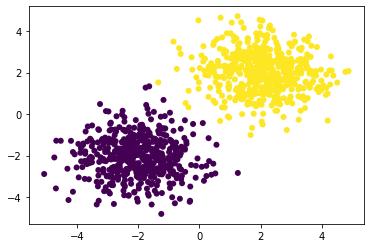

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

Current loss: 0.205337
Current loss: 0.011806


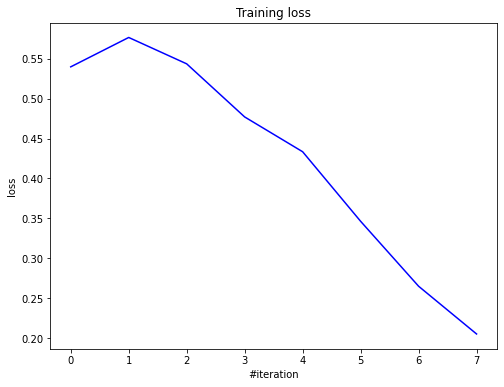

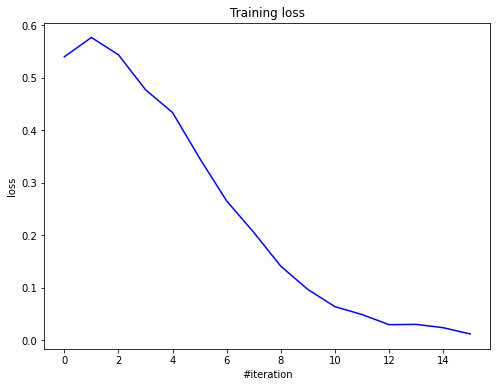

Current loss: 0.011806
Current loss: 0.003992


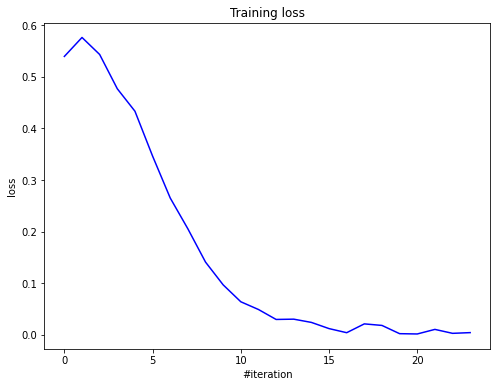

Current loss: 0.003992
Current loss: 0.001324
Current loss: 0.002725


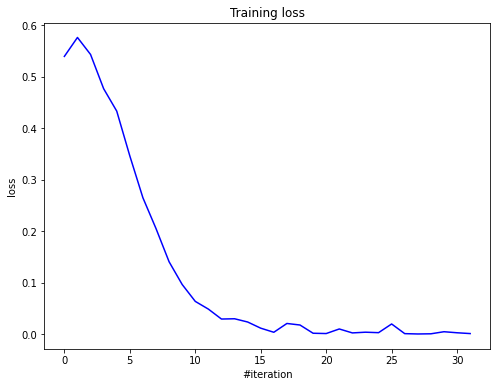

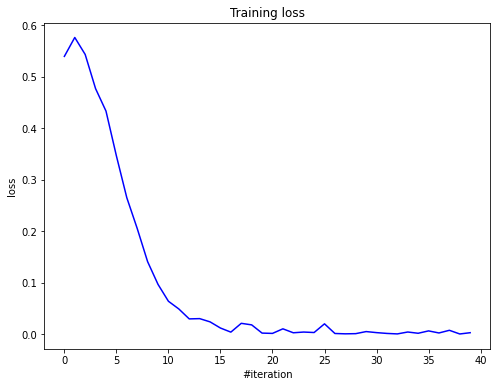

Current loss: 0.002725
Current loss: 0.001478


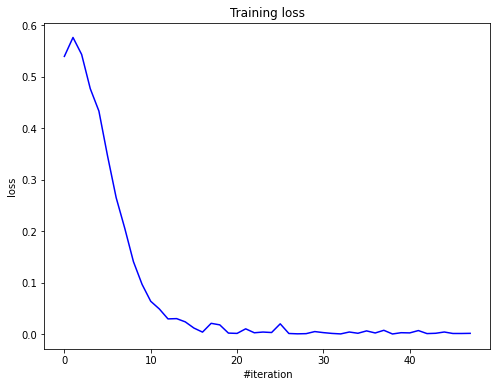

Current loss: 0.001478
Current loss: 0.001025


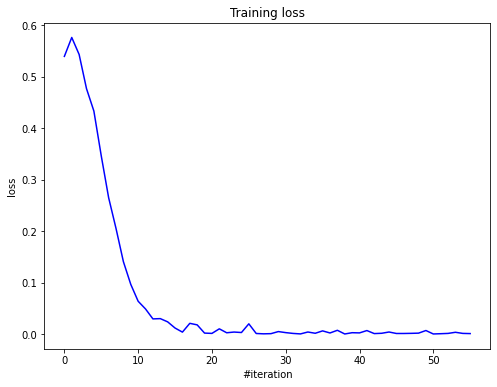

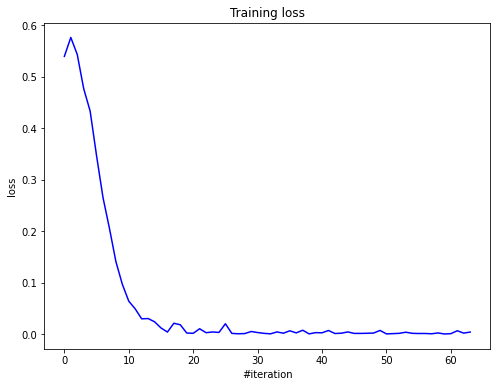

Current loss: 0.003862
Current loss: 0.002652


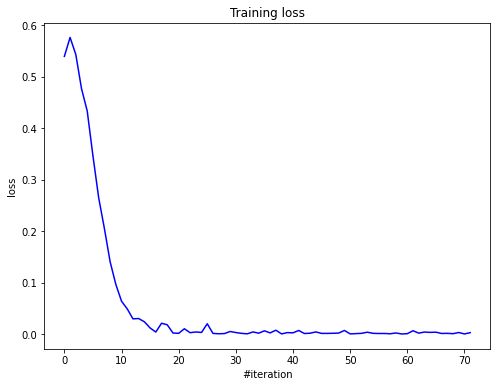

Current loss: 0.002652
Current loss: 0.000022
Current loss: 0.000011


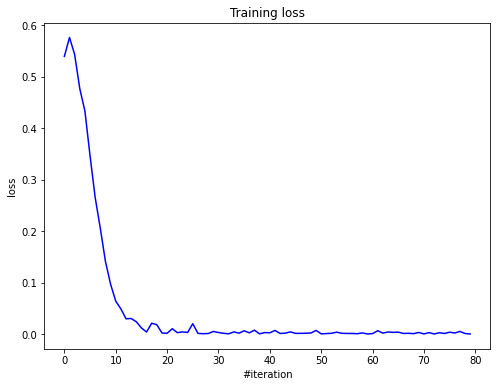

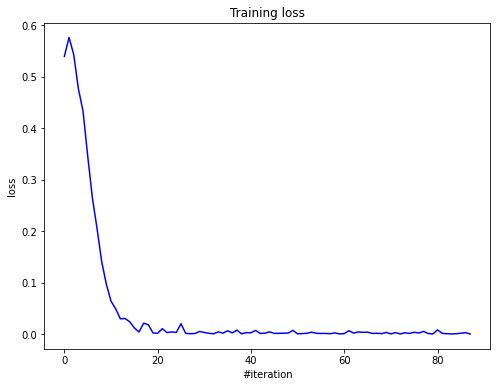

Current loss: 0.000011
Current loss: 0.004776


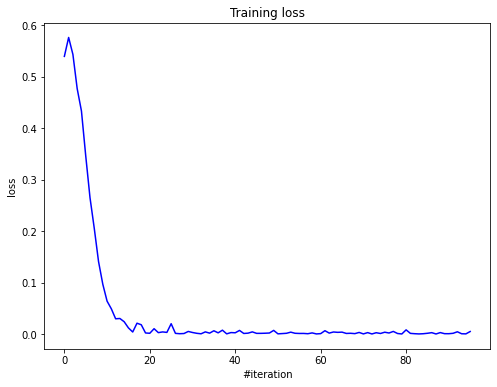

Current loss: 0.004776
Current loss: 0.000521


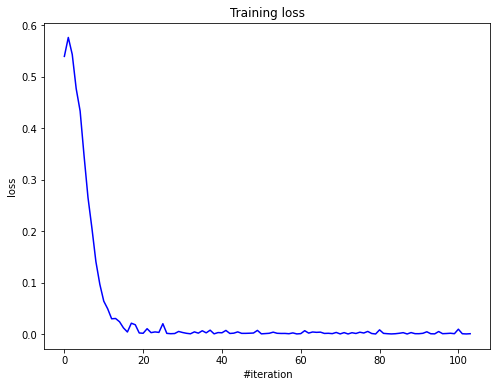

Current loss: 0.000521
Current loss: 0.004765
Current loss: 0.000060


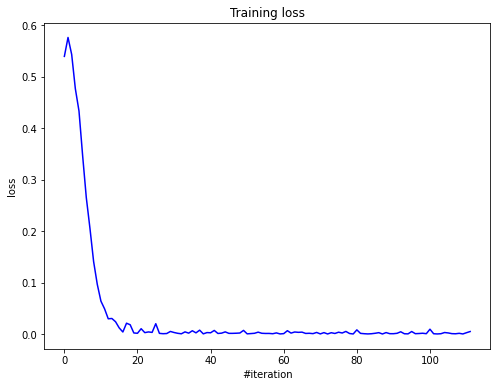

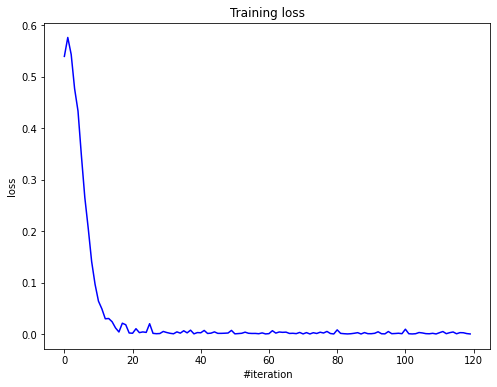

Current loss: 0.000060
Current loss: 0.000629
Current loss: 0.000549


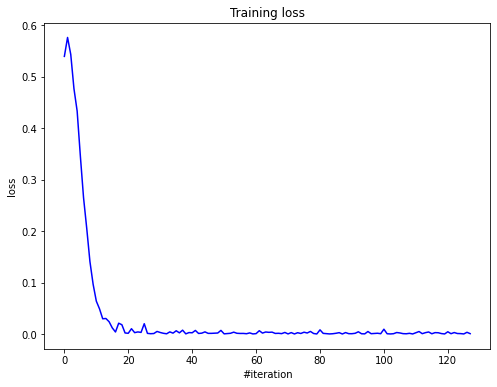

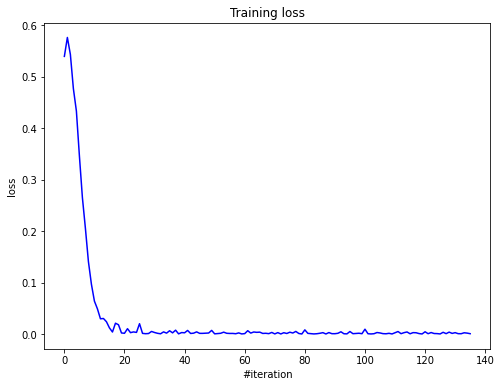

Current loss: 0.000549
Current loss: 0.000389
Current loss: 0.000019


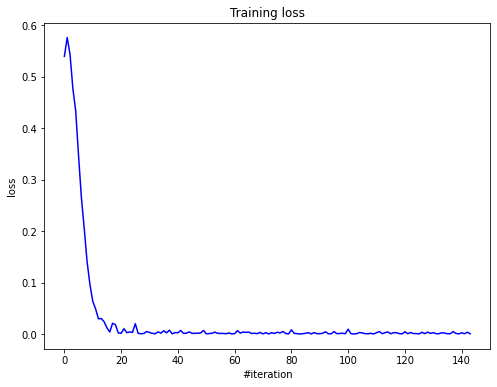

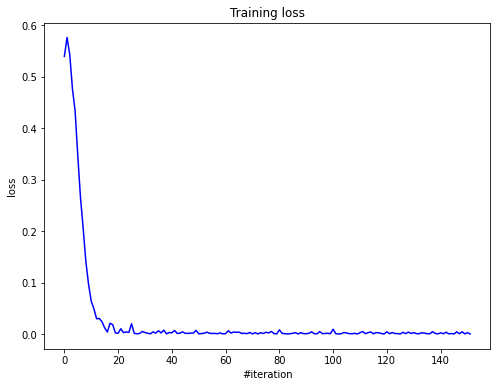

Current loss: 0.000019
Current loss: 0.001644


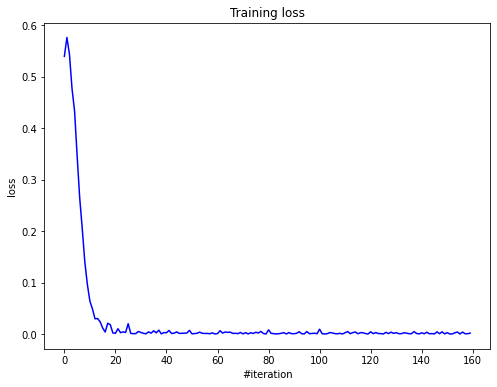

In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)
X_val = X_val.reshape(X_val.shape[0], 28*28)

X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_train_ohe = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_ohe = encoder.fit_transform(y_val.reshape(-1, 1))
y_test_ohe = encoder.transform(y_test.reshape(-1, 1))

In [11]:
encoder.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [12]:
# Your code goes here. ################################################
net_relu = Sequential()
net_relu.add(Linear(28*28, 100))
net_relu.add(ReLU())
net_relu.add(Linear(100,10))
net_relu.add(LogSoftMax())
criterion_relu = ClassNLLCriterion()

In [13]:
net_elu = Sequential()
net_elu.add(Linear(28*28, 100))
net_elu.add(ELU())
net_elu.add(Linear(100,10))
net_elu.add(LogSoftMax())
criterion_elu = ClassNLLCriterion()

In [14]:
net_leaky_relu = Sequential()
net_leaky_relu.add(Linear(28*28, 100))
net_leaky_relu.add(LeakyReLU())
net_leaky_relu.add(Linear(100,10))
net_leaky_relu.add(LogSoftMax())
criterion_leaky_relu = ClassNLLCriterion()

In [15]:
net_soft_plus = Sequential()
net_soft_plus.add(Linear(28*28, 100))
net_soft_plus.add(SoftPlus())
net_soft_plus.add(Linear(100,10))
net_soft_plus.add(LogSoftMax())
criterion_soft_plus = ClassNLLCriterion()

In [16]:
n_epoch = 40
batch_size = 5000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

def train(net, criterion, n_epoch, batch_size):
    train_loss = []
    test_loss = []
    val_loss = []
    
    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train_ohe), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)     
        
        net.evaluate()
        
        pred_train = net.forward(X_train)
        train_loss.append(criterion.forward(pred_train, y_train_ohe))
        
        pred_test = net.forward(X_test)
        test_loss.append(criterion.forward(pred_test, y_test_ohe))

        pred_val = net.forward(X_val)
        val_loss.append(criterion.forward(pred_val, y_val_ohe))
    
    return train_loss, test_loss, val_loss

Network without Batch Norm


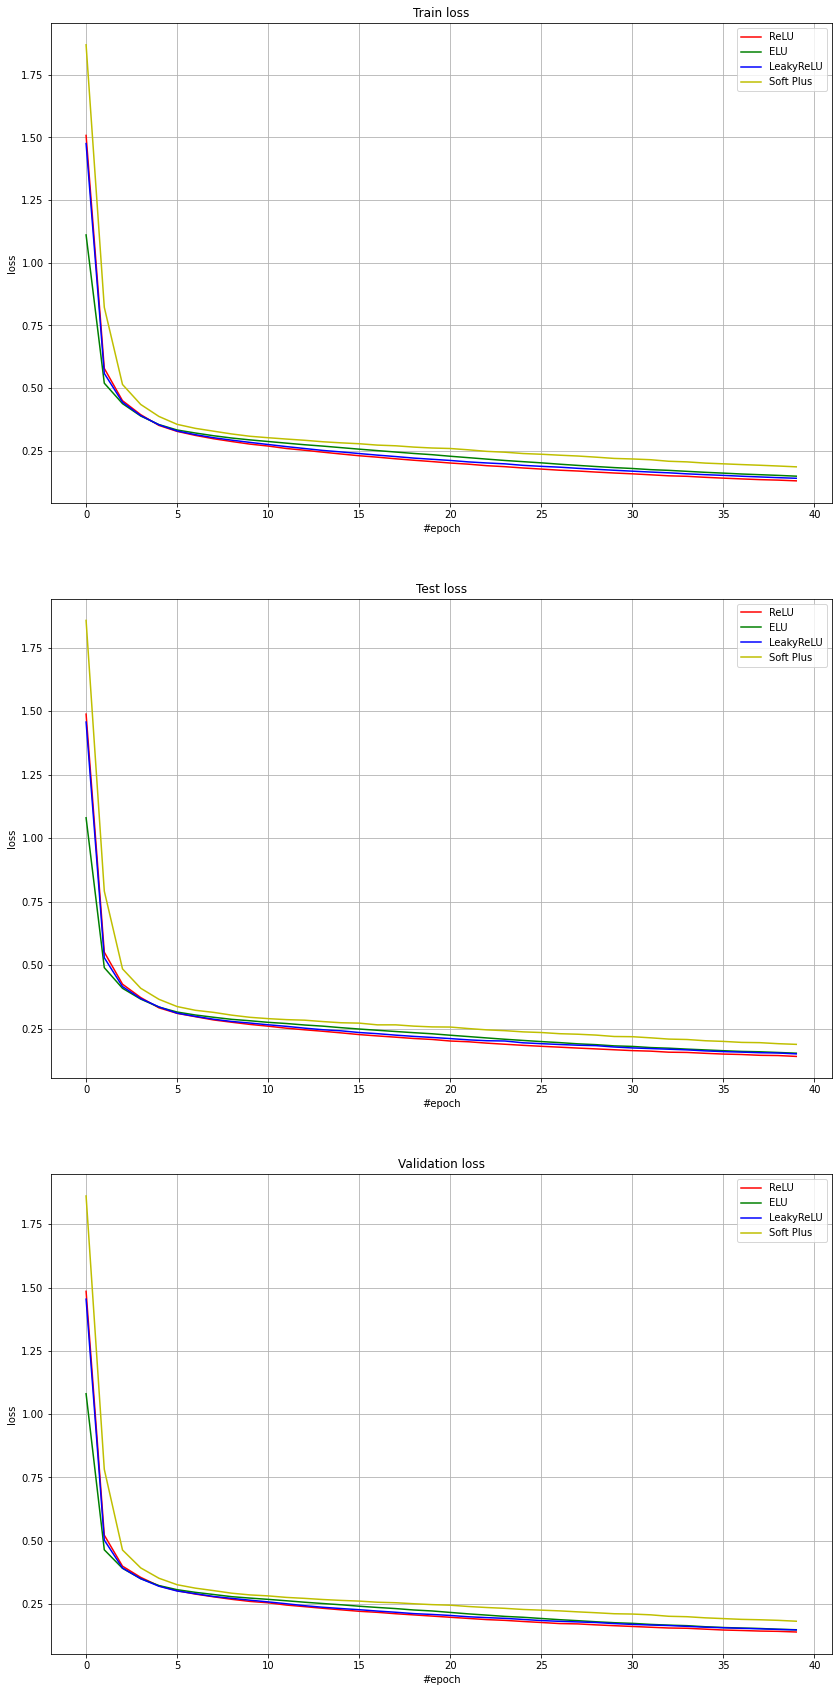

In [17]:
train_loss_relu, test_loss_relu, val_loss_relu = train(net_relu, criterion_relu, n_epoch, batch_size)
train_loss_elu, test_loss_elu, val_loss_elu = train(net_elu, criterion_elu, n_epoch, batch_size)
train_loss_leaky_relu, test_loss_leaky_relu, val_loss_leaky_relu = train(net_leaky_relu, criterion_leaky_relu, n_epoch, batch_size)
train_loss_soft_plus, test_loss_soft_plus, val_loss_soft_plus = train(net_soft_plus, criterion_soft_plus, n_epoch, batch_size)

print('Network without Batch Norm')

plt.figure(figsize=(14, 30))

plt.subplot(3,1,1)
plt.title("Train loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss_relu, 'r', label='ReLU')
plt.plot(train_loss_elu, 'g', label='ELU')
plt.plot(train_loss_leaky_relu, 'b', label='LeakyReLU')
plt.plot(train_loss_soft_plus, 'y', label='Soft Plus')
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.title("Test loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(test_loss_relu, 'r', label='ReLU')
plt.plot(test_loss_elu, 'g', label='ELU')
plt.plot(test_loss_leaky_relu, 'b', label='LeakyReLU')
plt.plot(test_loss_soft_plus, 'y', label='Soft Plus')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.title("Validation loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(val_loss_relu, 'r', label='ReLU')
plt.plot(val_loss_elu, 'g', label='ELU')
plt.plot(val_loss_leaky_relu, 'b', label='LeakyReLU')
plt.plot(val_loss_soft_plus, 'y', label='Soft Plus')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
net_bn = Sequential()
net_bn.add(Linear(28*28, 100))
net_bn.add(BatchNormalization())
net_bn.add(ChannelwiseScaling(100))
net_bn.add(ReLU())
net_bn.add(Linear(100, 10))
net_bn.add(BatchNormalization())
net_bn.add(ChannelwiseScaling(10))
net_bn.add(LogSoftMax())
criterion_bn = ClassNLLCriterion()

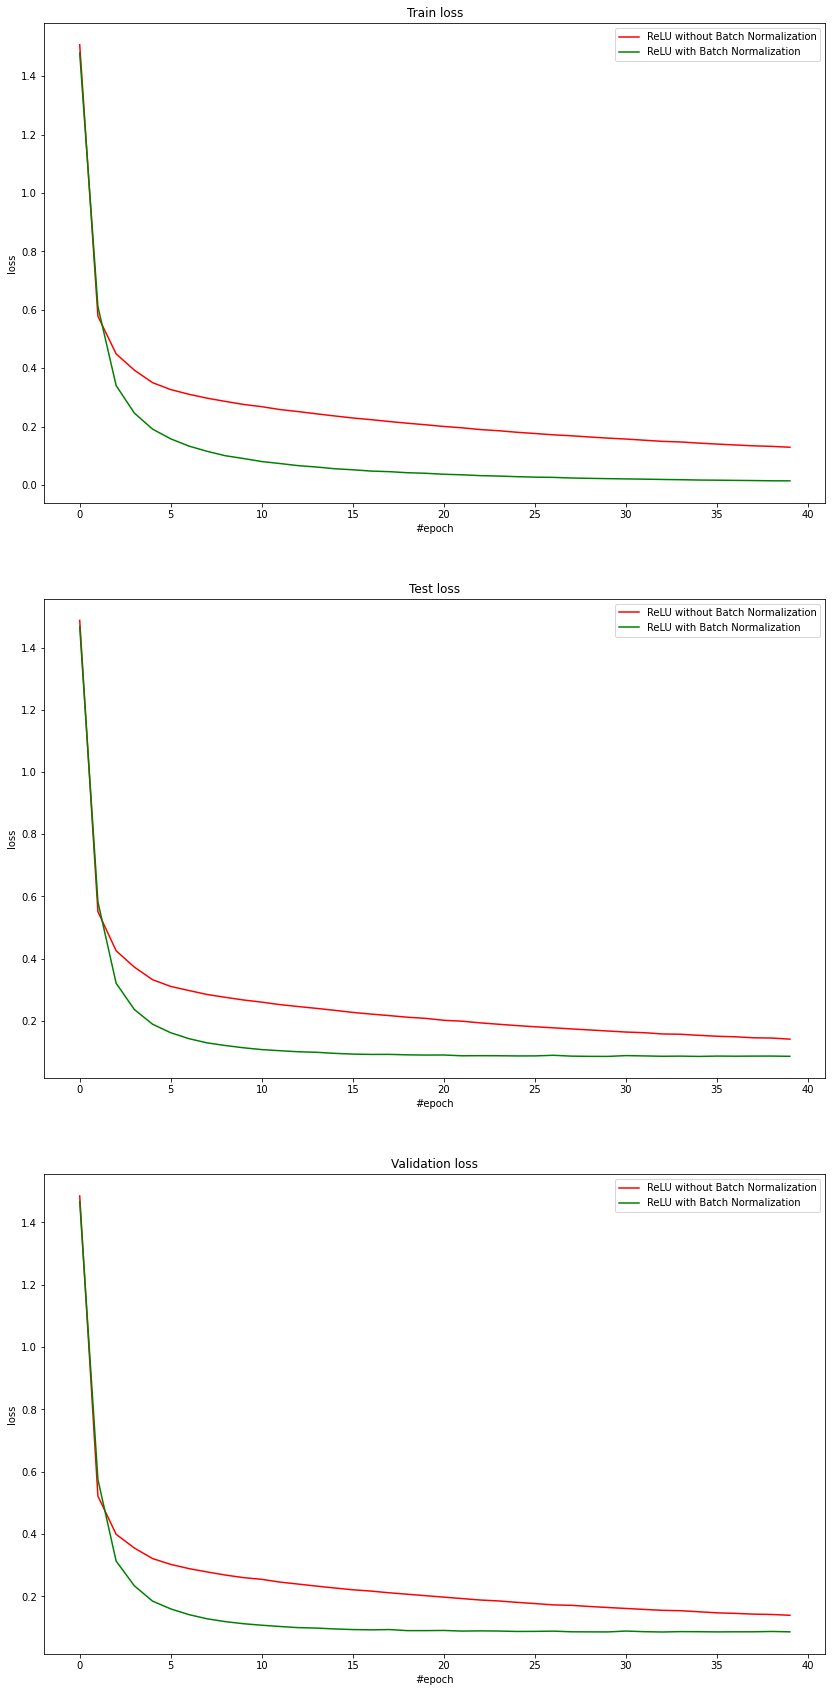

In [24]:
optimizer_state = {}
train_loss_bn, test_loss_bn, val_loss_bn = train(net_bn, criterion_bn, n_epoch, batch_size)

plt.figure(figsize=(14, 30))
plt.subplot(3,1,1)
plt.title("Train loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss_relu, 'r', label='ReLU without Batch Normalization')
plt.plot(train_loss_bn, 'g', label='ReLU with Batch Normalization')
plt.legend()

plt.subplot(3,1,2)
plt.title("Test loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(test_loss_relu, 'r', label='ReLU without Batch Normalization')
plt.plot(test_loss_bn, 'g', label='ReLU with Batch Normalization')
plt.legend()

plt.subplot(3,1,3)
plt.title("Validation loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(val_loss_relu, 'r', label='ReLU without Batch Normalization')
plt.plot(val_loss_bn, 'g', label='ReLU with Batch Normalization')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

From given results we see that the minimum losses are achieved with a ReLU function and the worst function is Soft Plus. In next tasks I will use the ReLU activation function. I used the ReLU when I was researching a neural network with Batch Normalization. On the charts we see the neural network with Batch Normalization allows to reduce losses during training.

In [25]:
# Your answer goes here. ################################################
net_with_adam = Sequential()
net_with_adam.add(Linear(28*28, 100))
net_with_adam.add(BatchNormalization())
net_with_adam.add(ChannelwiseScaling(100))
net_with_adam.add(ReLU())
net_with_adam.add(Linear(100,10))
net_with_adam.add(BatchNormalization())
net_with_adam.add(ChannelwiseScaling(10))
net_with_adam.add(LogSoftMax())
criterion_adam = ClassNLLCriterion()


net_with_sgd = Sequential()
net_with_sgd.add(Linear(28*28, 100))
net_with_sgd.add(BatchNormalization())
net_with_sgd.add(ChannelwiseScaling(100))
net_with_sgd.add(ReLU())
net_with_sgd.add(Linear(100,10))
net_with_sgd.add(BatchNormalization())
net_with_sgd.add(ChannelwiseScaling(10))
net_with_sgd.add(LogSoftMax())
criterion_sgd = ClassNLLCriterion()

In [26]:
train_loss_adam = []
test_loss_adam = []
val_loss_adam = []
    
train_loss_sgd = []
test_loss_sgd = []
val_loss_sgd = []    

n_epoch = 30

for i in range(n_epoch):
    net_with_adam.train()
    net_with_sgd.train()
    for x_batch, y_batch in get_batches((X_train, y_train_ohe), batch_size):

        net_with_adam.zeroGradParameters()
        predictions = net_with_adam.forward(x_batch)
        loss = criterion_adam.forward(predictions, y_batch)
        dp = criterion_adam.backward(predictions, y_batch)
        net_with_adam.backward(x_batch, dp)
        
        adam_optimizer(net_with_adam.getParameters(), 
             net_with_adam.getGradParameters(), 
             {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-7},
             {}) 
        
        net_with_sgd.zeroGradParameters()
        predictions = net_with_sgd.forward(x_batch)
        loss = criterion_sgd.forward(predictions, y_batch)
        dp = criterion_sgd.backward(predictions, y_batch)
        net_with_sgd.backward(x_batch, dp)
        
        sgd_momentum(net_with_sgd.getParameters(), 
                     net_with_sgd.getGradParameters(), 
                     {'learning_rate': 1e-1, 'momentum': 0.9},
                     {})     

    net_with_adam.evaluate()
    net_with_sgd.evaluate()
    
    pred_train = net_with_adam.forward(X_train)
    train_loss_adam.append(criterion_adam.forward(pred_train, y_train_ohe))
    pred_test = net_with_adam.forward(X_test)
    test_loss_adam.append(criterion_adam.forward(pred_test, y_test_ohe))
    pred_val = net_with_adam.forward(X_val)
    val_loss_adam.append(criterion_adam.forward(pred_val, y_val_ohe))
    
    pred_train = net_with_sgd.forward(X_train)
    train_loss_sgd.append(criterion_sgd.forward(pred_train, y_train_ohe))
    pred_test = net_with_sgd.forward(X_test)
    test_loss_sgd.append(criterion_sgd.forward(pred_test, y_test_ohe))
    pred_val = net_with_sgd.forward(X_val)
    val_loss_sgd.append(criterion_sgd.forward(pred_val, y_val_ohe))

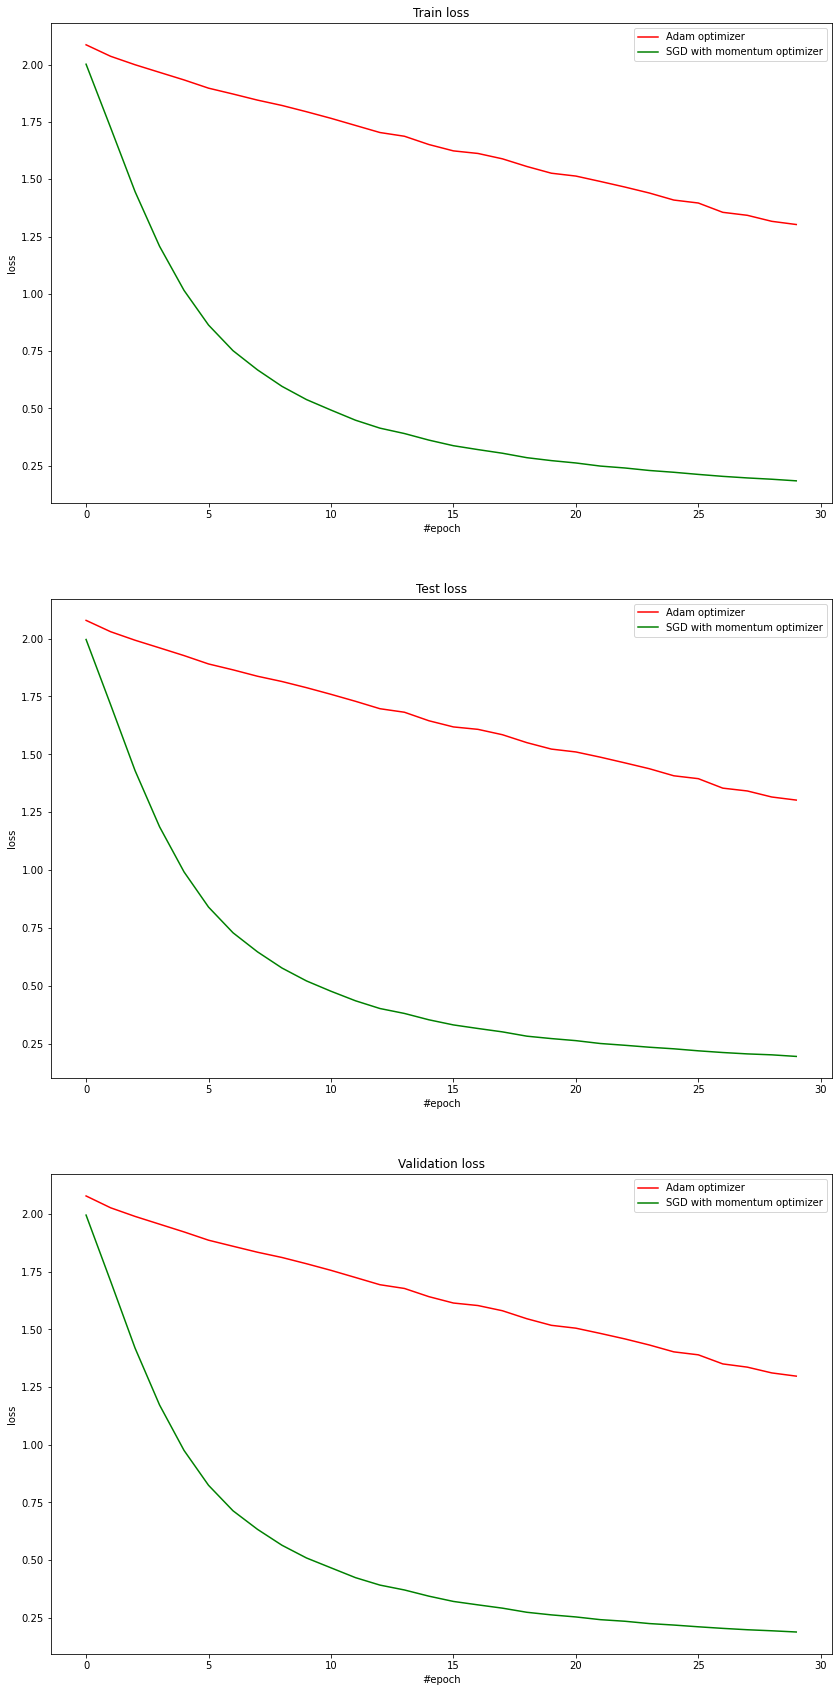

In [27]:
plt.figure(figsize=(14, 30))
plt.subplot(3,1,1)
plt.title("Train loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss_adam, 'r', label='Adam optimizer')
plt.plot(train_loss_sgd, 'g', label='SGD with momentum optimizer')
plt.legend()

plt.subplot(3,1,2)
plt.title("Test loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(test_loss_adam, 'r', label='Adam optimizer')
plt.plot(test_loss_sgd, 'g', label='SGD with momentum optimizer')
plt.legend()

plt.subplot(3,1,3)
plt.title("Validation loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(val_loss_adam, 'r', label='Adam optimizer')
plt.plot(val_loss_sgd, 'g', label='SGD with momentum optimizer')
plt.legend()
plt.show()

On the mnist dataset SGD with momentum optimizer converge to the optimum value faster than the adam optimizer.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [28]:
# Your code goes here. ################################################
def accuracy(y_predict, y_true):
    return np.mean(np.argmax(y_predict, axis=1) == y_true)

In [39]:
net_with_dropout = Sequential()
net_with_dropout.add(Linear(28*28, 128))
net_with_dropout.add(Dropout(0.5))
net_with_dropout.add(ReLU())
net_with_dropout.add(Linear(128,10))
net_with_dropout.add(LogSoftMax())
criterion_with_dropout = ClassNLLCriterion()

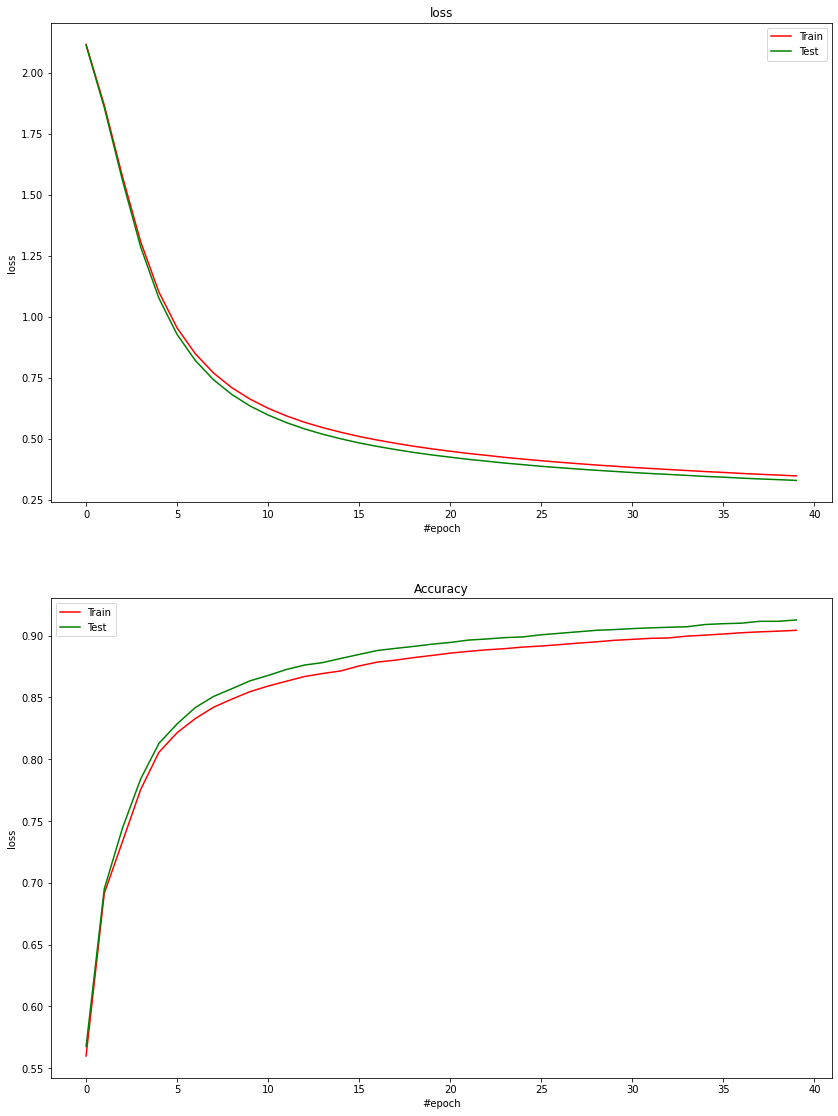

In [40]:
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

n_epoch = 40

for i in range(n_epoch):
    net_with_dropout.train()
    for x_batch, y_batch in get_batches((X_train, y_train_ohe), batch_size):

        net_with_dropout.zeroGradParameters()
        predictions = net_with_dropout.forward(x_batch)
        loss = criterion_with_dropout.forward(predictions, y_batch)
        dp = criterion_with_dropout.backward(predictions, y_batch)
        net_with_dropout.backward(x_batch, dp)
        
        sgd_momentum(net_with_dropout.getParameters(), 
                     net_with_dropout.getGradParameters(), 
                     {'learning_rate': 1e-1, 'momentum': 0.9},
                     {})  
          
    net_with_dropout.evaluate()
    
    pred_train = net_with_dropout.forward(X_train)
    train_loss.append(criterion_with_dropout.forward(pred_train, y_train_ohe))
    train_accuracy.append(accuracy(pred_train, y_train))
    
    pred_test = net_with_dropout.forward(X_test)
    test_loss.append(criterion_with_dropout.forward(pred_test, y_test_ohe))
    test_accuracy.append(accuracy(pred_test, y_test))


plt.figure(figsize=(14, 30))
plt.subplot(3,1,1)
plt.title("loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss, 'r', label='Train')
plt.plot(test_loss, 'g', label='Test')
plt.legend()

plt.subplot(3,1,2)
plt.title("Accuracy")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_accuracy, 'r', label='Train')
plt.plot(test_accuracy, 'g', label='Test')
plt.legend()

Print here your accuracy on test set. It should be around 90%.

In [34]:
# Your answer goes here. ################################################
net_bn.evaluate()
y_pred = net_bn.forward(X_test)
print("Network with BatchNormalization gave {} accuracy on test data.".format(accuracy(y_pred, y_test)))

Network with BatchNormalization gave 0.9769 accuracy on test data.


In [42]:
# Your answer goes here. ################################################
net_with_dropout.evaluate()
y_pred = net_with_dropout.forward(X_test)
print("Network with Dropout gave {} accuracy on test data.".format(accuracy(y_pred, y_test)))

Network with Dropout gave 0.9127 accuracy on test data.
